In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
import math
import pandas as pd
import random
import wandb

from torch import nn, optim
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from torch.utils.data import DataLoader, Dataset, ConcatDataset

from datasets import load_dataset
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt

from models.ConvolutionalUNet import ConvolutionalUNet
from data.ImageDataset import ImageDataset

/Users/josh/miniconda3/envs/nlp-hw2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# dynamically select device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [3]:
dataset = ImageDataset(
    dataset_name="Donghyun99/Stanford-Cars",
    max_examples=100,
    image_size=128,
    bs=32
)

[dataset] loaded


In [4]:
dataloader = dataset.create_dataloader()

torch.Size([3, 128, 128])
tensor(1.) tensor(-1.)
tensor(1.) tensor(0.)


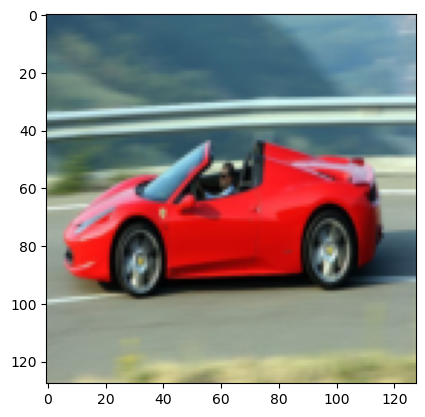

In [5]:
# get example
example = dataset.data[0]
print(example.shape)
print(torch.max(example), torch.min(example))
# rescale from [-1, 1] to [0, 1]
example = (example + 1) / 2
print(torch.max(example), torch.min(example))
plt.imshow(example.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9270742..2.5219393].


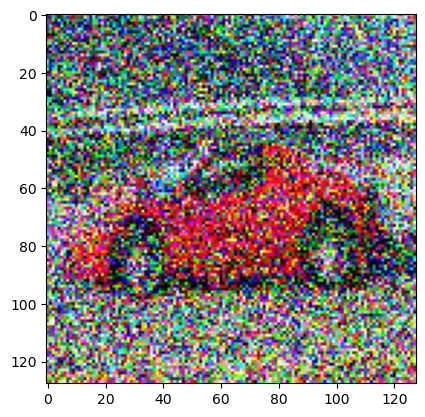

In [15]:
batch = example.unsqueeze(0).to(device)
t = 0.75
noise = torch.randn(batch.size(), device=batch.device, dtype=batch.dtype).to(device)
diffuse_batch = math.sqrt(t) * batch + math.sqrt(1 - t) * noise
plt.imshow(diffuse_batch.squeeze(0).permute(1, 2, 0).cpu().numpy())

In [16]:
model  = ConvolutionalUNet().to(device)

In [17]:
# dry run
x = torch.randn(32, 3, 128, 128).to(device)
y = model(x)
print(y.shape) # should be [32, 3, 256, 256]

torch.Size([32, 3, 128, 128])


In [18]:
train_config = {
    'max_examples': 1000,
    'max_len': 1000,
    'bs': 32,
    'lr': 0.0001,
    'weight_decay': 0.000001,
    'max_epochs': 10
}

In [19]:
# optimizer and criterion
optimizer = optim.AdamW(model.parameters(), lr=train_config['lr'], weight_decay=train_config['weight_decay'])
criterion = nn.MSELoss()

# construct linear warmup and cosine annealing cooldown
warmup_epochs = int(train_config['max_epochs'] / 10)
cooldown_epochs = train_config['max_epochs'] - warmup_epochs
epoch_len = len(dataloader)

linear = LinearLR(optimizer, start_factor=0.25, end_factor=1.0, total_iters=warmup_epochs*epoch_len)
cosine = CosineAnnealingLR(optimizer, T_max=cooldown_epochs*epoch_len, eta_min=1e-6)
scheduler = SequentialLR(optimizer, schedulers=[linear, cosine], milestones=[warmup_epochs*epoch_len])

model.train()

# main training loop
pbar = tqdm(total=(train_config['max_epochs'])*epoch_len, desc="Training Iterations", unit="batch")
iteration = 0
for epoch in range(train_config['max_epochs']):
    # minibatch gradient descent
    for batch_idx, batch in enumerate(dataloader):
        # pick noising rate
        t = random.uniform(0.01, 0.99)

        # run batch through diffusion
        batch = batch.to(device)
        noise = torch.randn(batch.size(), device=x.device, dtype=x.dtype).to(device)
        diffuse_batch = math.sqrt(t) * batch + math.sqrt(1 - t) * noise

        # forward pass
        noise_pred = model(diffuse_batch)

        # compute L2 loss between predicted noise and true noise
        loss = criterion(noise_pred, noise)
        print(loss)

        # optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        pbar.update(1)
        iteration += 1
        scheduler.step()


pbar.close()

Training Iterations:   0%|          | 0/30 [00:00<?, ?batch/s]

tensor(1.0076, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:   3%|▎         | 1/30 [00:05<02:43,  5.64s/batch]

tensor(1.0099, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:   7%|▋         | 2/30 [00:07<01:42,  3.66s/batch]

tensor(1.0078, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  10%|█         | 3/30 [00:11<01:37,  3.60s/batch]/Users/josh/miniconda3/envs/nlp-hw2/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


tensor(1.0061, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  13%|█▎        | 4/30 [00:20<02:32,  5.88s/batch]

tensor(1.0044, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  17%|█▋        | 5/30 [00:24<02:04,  4.97s/batch]

tensor(1.0032, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  20%|██        | 6/30 [00:28<01:52,  4.70s/batch]

tensor(1.0004, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  23%|██▎       | 7/30 [00:36<02:14,  5.84s/batch]

tensor(0.9987, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  27%|██▋       | 8/30 [00:38<01:44,  4.76s/batch]

tensor(1.0020, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  30%|███       | 9/30 [00:42<01:29,  4.28s/batch]

tensor(0.9970, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  33%|███▎      | 10/30 [00:53<02:06,  6.33s/batch]

tensor(0.9964, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  37%|███▋      | 11/30 [00:55<01:38,  5.17s/batch]

tensor(0.9991, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  40%|████      | 12/30 [00:59<01:28,  4.91s/batch]

tensor(0.9935, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  43%|████▎     | 13/30 [01:10<01:52,  6.59s/batch]

tensor(0.9917, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  47%|████▋     | 14/30 [01:14<01:34,  5.90s/batch]

tensor(0.9876, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  50%|█████     | 15/30 [01:18<01:18,  5.21s/batch]

tensor(0.9818, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  53%|█████▎    | 16/30 [01:26<01:27,  6.24s/batch]

tensor(0.9800, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  57%|█████▋    | 17/30 [01:29<01:06,  5.10s/batch]

tensor(0.9841, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  60%|██████    | 18/30 [01:32<00:54,  4.55s/batch]

tensor(0.9793, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  63%|██████▎   | 19/30 [01:40<00:59,  5.44s/batch]

tensor(0.9743, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  67%|██████▋   | 20/30 [01:42<00:45,  4.50s/batch]

tensor(0.9994, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  70%|███████   | 21/30 [01:45<00:36,  4.02s/batch]

tensor(0.9738, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  73%|███████▎  | 22/30 [01:53<00:42,  5.32s/batch]

tensor(0.9771, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  77%|███████▋  | 23/30 [01:56<00:30,  4.42s/batch]

tensor(0.9764, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  80%|████████  | 24/30 [01:59<00:24,  4.00s/batch]

tensor(0.9746, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  83%|████████▎ | 25/30 [02:06<00:25,  5.11s/batch]

tensor(0.9746, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  87%|████████▋ | 26/30 [02:09<00:17,  4.26s/batch]

tensor(0.9751, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  90%|█████████ | 27/30 [02:12<00:11,  3.87s/batch]

tensor(0.9771, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  93%|█████████▎| 28/30 [02:21<00:11,  5.57s/batch]

tensor(0.9786, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations:  97%|█████████▋| 29/30 [02:24<00:04,  4.67s/batch]

tensor(0.9869, device='mps:0', grad_fn=<MseLossBackward0>)


Training Iterations: 100%|██████████| 30/30 [02:28<00:00,  4.95s/batch]
